<a href="https://colab.research.google.com/github/te-ha-en/AH2179/blob/main/Project_AH2179.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and function definitions



In [57]:
!pip install keras-tuner
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, max_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
'''Code for bus arrival delay prediction for project in AH2179
    ChatGPT and Gemini used in development for troubleshooting and fixing errors'''

#Functions anbd dataset imports
#
#

#Utilise keras-tuner - using a Hypermodel for hyperprameter tuning
class DelayHPM(kt.HyperModel):
  #Initialisation requires passing the dimensions for the specific model instance
  def __init__(self, input_shape):
    self.input_shape = input_shape

  def build(self, hp):
      model = Sequential()
      model.add(Input(shape=self.input_shape))
      # Tune the number of Dense layers from 1-4:
      for i in range(hp.Int("num_layers", 1, 4)):
            model.add(
                Dense(
                    #Tune the number of units per layer separately from 16 to 160:
                    units=hp.Int(f"units_{i}", min_value=16, max_value=160, step=16),
                    #Tune the activation function for the layer units:
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
      #Tuning of an optional dropout layer:
      if hp.Boolean("dropout"):
          model.add(Dropout(rate=0.25))
      #Adding a final 1-unit dense layer for regression purposes:
      model.add(Dense(1))
      #Tuning of learning rate:
      learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
      model.compile(
          optimizer=Adam(learning_rate=learning_rate),
          loss="mae",
          metrics=['mae'],
      )
      return model

def assessModel(y_test, y_pred):
  #MAE
  mae = mean_absolute_error(y_test, y_pred)
  #MSE
  mse = mean_squared_error(y_test, y_pred)
  #MAPE
  mape = mean_absolute_percentage_error(y_test, y_pred)
  #RMSE
  rmse = root_mean_squared_error(y_test, y_pred)
  #R2-score
  r2 = r2_score(y_test, y_pred)
  #Max error
  me = max_error(y_test, y_pred)
  # Print the calculated metrics.
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Percentage Error: {mape}")
  print(f"Root Mean Square Error: {rmse}")
  print(f"R-squared: {r2}")
  print(f"Maximum error: {me}")
  return [mae, mse, r2, me]


def plotPredictions(y_test, y_pred, model_type):
  # Create a scatter plot to visualize the relationship
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values


  # Add labels and title
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title(f"Actual vs. Predicted Values - {model_type}")

  # Add a diagonal line for reference (perfect predictions)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
  plt.xlim(-100, max(y_test))
  plt.ylim(-100, max(y_test))

  # Show the plot
  plt.show()

def getStatistics(df):
    print(df.describe())
    print(df.var())
    print(df.skew())
    print(df.kurt())

def getFeatureImportance(model):
  # Get importance
  importance = model.feature_importances_
  for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')
  plt.barh([x for x in range(len(importance))], importance)
  plt.show()

#Bus 4 operation data:
file_url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/3e5a31018e33c88bcb58d44019750f5d4dccc443/ProjectAssignmentData/Dataset-PT.csv'
bus_df = pd.read_csv(file_url, header=1)

#Dropping unused and categorical variables
df = bus_df.drop(['Calendar_date', 'route_id','bus_id','weather', 'temperature', 'day_of_week', 'time_of_day'], axis=1)

#Check for missing data for any column - has been verified
# missing_entries = pd.isnull(df).sum()
# print('NaN values in dataset: \n', missing_entries)

#Focus on weekday peaks
df_peak = df.query('`factor(day_of_week)weekday` == 1 and (`factor(time_of_day)Afternoon_peak` == 1 or `factor(time_of_day)Morning_peak` == 1)')

#Other times for evalutation of generalization:
df_offpeak = df.query('`factor(day_of_week)weekday` == 1 and `factor(time_of_day)Off-peak` == 1')
df_weekend = df.query('`factor(day_of_week)weekday` == 0')



In [41]:

#Exploaratory statistics
getStatistics(df_offpeak)
getStatistics(df_weekend)

       stop_sequence  arrival_delay     dwell_time  \
count  214515.000000  214515.000000  214515.000000   
mean       14.000000     128.158222      32.321898   
std         7.788899     178.609879      25.970414   
min         1.000000   -1349.000000       0.000000   
25%         7.000000      13.000000      18.000000   
50%        14.000000      86.000000      26.000000   
75%        21.000000     200.000000      42.000000   
max        27.000000    2257.000000     775.000000   

       travel_time_for_previous_section  scheduled_travel_time  \
count                     214515.000000          214515.000000   
mean                          71.216372             105.663100   
std                           37.245956              36.166288   
min                            0.000000              38.000000   
25%                           45.000000              76.000000   
50%                           64.000000             104.000000   
75%                           93.000000            

       stop_sequence  arrival_delay     dwell_time  \
count    203634.0000  203634.000000  203634.000000   
mean         14.0000     100.294769      33.934461   
std           7.7889     182.783157      28.991096   
min           1.0000   -3493.000000       0.000000   
25%           7.0000      -8.000000      18.000000   
50%          14.0000      61.000000      26.000000   
75%          21.0000     169.000000      43.000000   
max          27.0000    2210.000000    1616.000000   

       travel_time_for_previous_section  scheduled_travel_time  \
count                     203634.000000          203634.000000   
mean                          74.783101             113.001267   
std                           39.320421              37.654852   
min                            0.000000              38.000000   
25%                           47.000000              82.000000   
50%                           68.000000             108.000000   
75%                           98.000000            

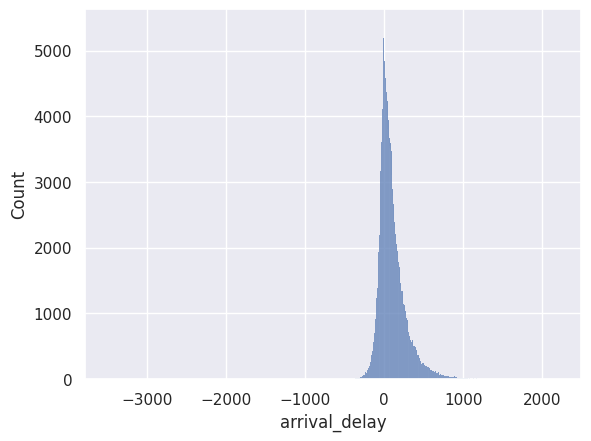

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Further exploratory statistics
sns.histplot(x=df_peak['arrival_delay'],)

getStatistics(df_peak)


In [43]:
#Correlation between variables
corr_matrix = df_peak.corr(numeric_only=True)
corr_matrix['arrival_delay'].sort_values(ascending=False)

,arrival_delay
arrival_delay,1.000000
upstream_stop_delay,0.967111
origin_delay,0.664489
previous_bus_delay,0.290083
travel_time_for_previous_section,0.127680
dwell_time,0.097849
stop_sequence,0.039815
factor(weather)Rain,0.019750
factor(weather)Snow,0.017602
factor(weather)Light_Snow,0.014013


# Prediction without using RT-variables

In [44]:
#Model training and saving of the best preforming model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

#Drop real-time variables freom dataset
df_nrt = df_peak.drop(['upstream_stop_delay','previous_bus_delay','previous_trip_travel_time','travel_time_for_previous_section','dwell_time'], axis = 1)

#Small subset used for development -Takes a random sample of 5000 entries:
df_nrt_dev = df_nrt.sample(n=5000, random_state=21)

y_nrt = df_nrt_dev['arrival_delay']
x_nrt = df_nrt_dev.drop(['arrival_delay'], axis=1)

#Do a 75-25 training/test split
X_nrt_train, X_nrt_test, y_nrt_train, y_nrt_test = train_test_split(x_nrt, y_nrt, test_size=0.25, random_state=21)

#Scale data using a StandardScaler
scaler = StandardScaler()
X_nrt_train_scaled = scaler.fit_transform(X_nrt_train)
X_nrt_test_scaled = scaler.transform(X_nrt_test)

# #Tune the model hyperparameters using a Hypermodel tuner to find the optimal model configuration
nrt_input_shape = (X_nrt_train_scaled.shape[1],)
print(nrt_input_shape)

nrt_hypermodel = DelayHPM(nrt_input_shape)

nrt_tuner = kt.Hyperband(
    nrt_hypermodel,
    objective='val_loss',
    max_epochs=50,
    seed=21,
    overwrite=True)

nrt_tuner.search(X_nrt_train_scaled, y_nrt_train, validation_data=(X_nrt_test_scaled, y_nrt_test))
best_nrt_model = nrt_tuner.get_best_models()[0]
best_nrt_model.save('NRT_model.keras')


Trial 90 Complete [00h 00m 29s]
val_loss: 108.00336456298828

Best val_loss So Far: 91.31230926513672
Total elapsed time: 00h 13m 16s


Best preforming NN-model - Simple senario:


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,181 (110.09 KB)

 Trainable params: 9,393 (36.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,788 (73.39 KB)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
<class 'pandas.core.frame.DataFrame'>
Index: 203634 entries, 3186 to 544832
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   stop_sequence                      203634 non-null  int64  
 1   arrival_delay                      203634 non-null  int64  
 2   scheduled_travel_time              203634 non-null  int64  
 3   origin_delay                       203634 non-null  int64  
 4   traffic_condition                  203634 non-null  float64
 5   recurrent_delay                    203634 non-null  float64
 6   factor(weather)Light_Rain          203634 non-null  int64  
 7   factor(weather)Light_Snow          203634 non-null  int64  
 8   factor(weather)Normal              203634 non-null  int64  
 9   factor(weather)Rain                203634 non-null  int64  
 10  factor(weather)Snow                203634 non-null  int64  
 11  fa

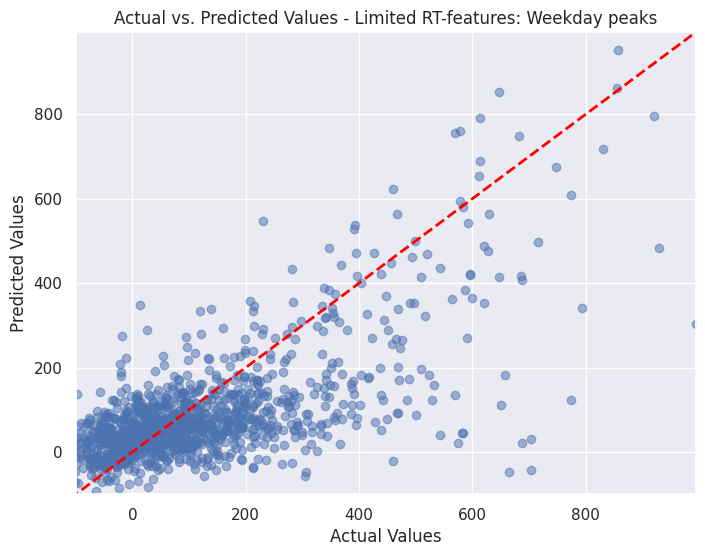

In [45]:
#Loading developed model and evaluating preformance metrics
best_nrt_model = tf.keras.models.load_model("NRT_model.keras")
print('Best preforming NN-model - Simple senario:')
best_nrt_model.summary()
#Test the prediction accuracy of the trained model
y_nrt_pred = best_nrt_model.predict(X_nrt_test_scaled)
df_nrt.info()

assessModel(y_nrt_test, y_nrt_pred)

plotPredictions(y_nrt_test,y_nrt_pred,'Limited RT-features: Weekday peaks')

# Using Real-time variables

Trial 90 Complete [00h 00m 30s]
val_loss: 50.05291748046875

Best val_loss So Far: 14.083578109741211
Total elapsed time: 00h 14m 50s
Best preforming NN-model - Simple senario:


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error: 14.083576202392578
Mean Squared Error: 411.2791442871094
Mean Absolute Percentage Error: 227893212872704.0
Root Mean Square Error: 20.280017852783203
R-squared: 0.9874486923217773
Maximum error: 175.53201293945312


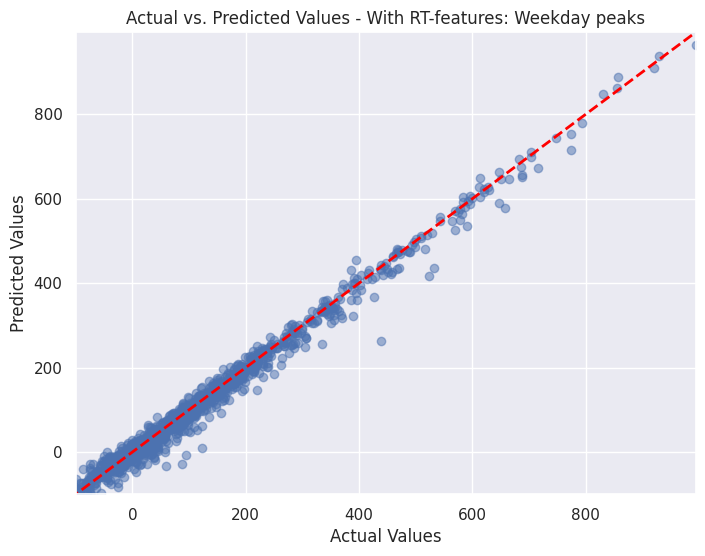

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
#Model training and saving of the best preforming model

#Small subset used for development - Takes a random sample of 5000 entries :
df_peak_dev = df_peak.sample(n=5000, random_state=21)

y = df_peak_dev['arrival_delay']
x = df_peak_dev.drop(['arrival_delay'], axis=1)

#Do a 75-25 training/test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=21)

#Scale data using a StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
print(input_shape)

hypermodel = DelayHPM(input_shape)

tuner = kt.Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=50,
    seed=21,
    overwrite=True)

tuner.search(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test))
best_model = tuner.get_best_models()[0]
best_model.save("RT_model.keras")
best_model = tf.keras.models.load_model("RT_model.keras")
print('Best preforming NN-model - Simple senario:')
best_model.summary()

#Test the prediction accuracy of the trained model
y_pred = best_model.predict(X_test_scaled)

assessModel(y_test, y_pred)

plotPredictions(y_test,y_pred, 'With RT-features: Weekday peaks')

Best preforming NN-model - Simple senario:


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error: 14.083576202392578
Mean Squared Error: 411.2791442871094
Mean Absolute Percentage Error: 227893212872704.0
Root Mean Square Error: 20.280017852783203
R-squared: 0.9874486923217773
Maximum error: 175.53201293945312


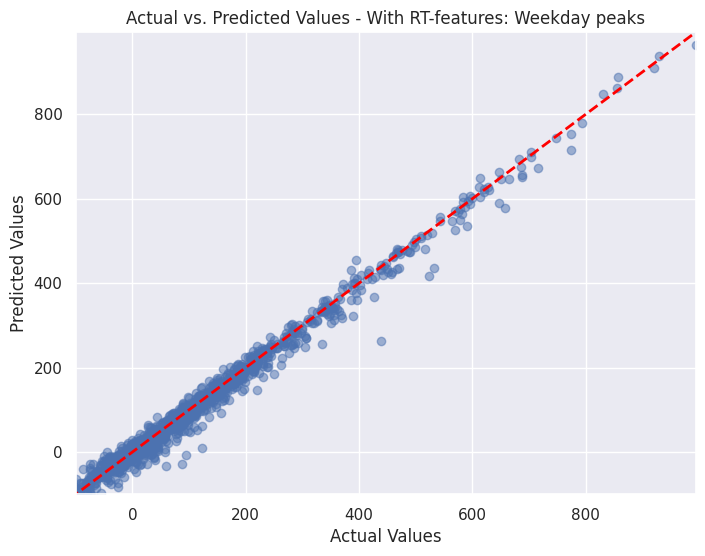

In [47]:
#Loading developed model and evaluating preformance metrics
best_model = tf.keras.models.load_model("RT_model.keras")
print('Best preforming NN-model - Simple senario:')
best_model.summary()

#Test the prediction accuracy of the trained model
y_pred = best_model.predict(X_test_scaled)

assessModel(y_test, y_pred)

plotPredictions(y_test,y_pred, 'With RT-features: Weekday peaks')

# Linear Regression

Mean Absolute Error: 97.69771329740999
Mean Squared Error: 18294.203027479016
Mean Absolute Percentage Error: 926507423750566.2
Root Mean Square Error: 135.25606466062442
R-squared: 0.44170318163374944
Maximum error: 684.9032038148214


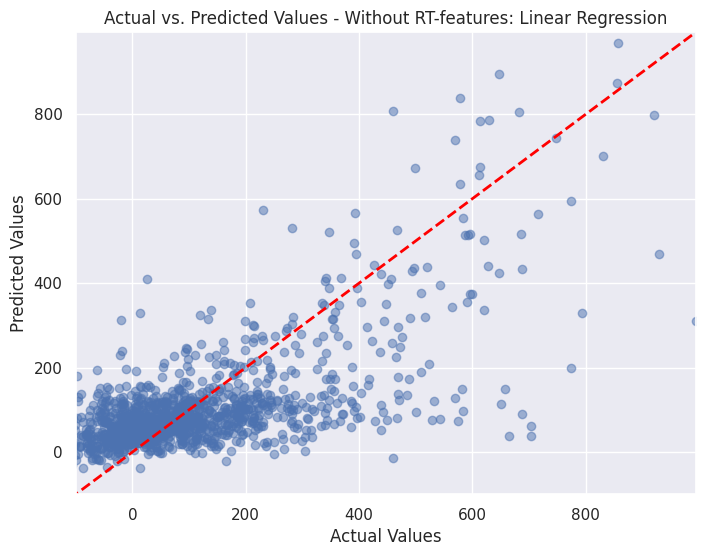

Mean Absolute Error: 13.763722968897582
Mean Squared Error: 389.78224065630553
Mean Absolute Percentage Error: 263554999383063.6
Root Mean Square Error: 19.742903551815917
R-squared: 0.9881047463785543
Maximum error: 182.65437335092236


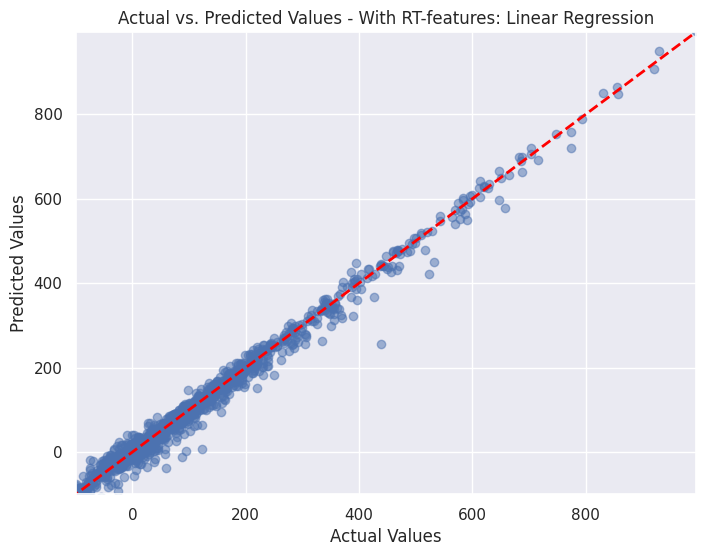

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

'''Trying a simple LinearRegression for the RT-features scenario'''
lin_model_nrt = LinearRegression()
lin_model_nrt.fit(X_nrt_train, y_nrt_train)
lin_nrt_pred = lin_model_nrt.predict(X_nrt_test)

assessModel(y_nrt_test, lin_nrt_pred)

#Plot predictions:
plotPredictions(y_nrt_test, lin_nrt_pred, 'Without RT-features: Linear Regression')

'''Trying a simple LinearRegression for the RT-features scenario'''
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)

assessModel(y_test, lin_pred)

#Plot predictions:
plotPredictions(y_test, lin_pred, 'With RT-features: Linear Regression')




#Tests using weekend and off-peak data

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error: 103.76775360107422
Mean Squared Error: 22759.0390625
Mean Absolute Percentage Error: 192546185674752.0
Root Mean Square Error: 150.86099243164062
R-squared: 0.316672146320343
Maximum error: 846.5146026611328


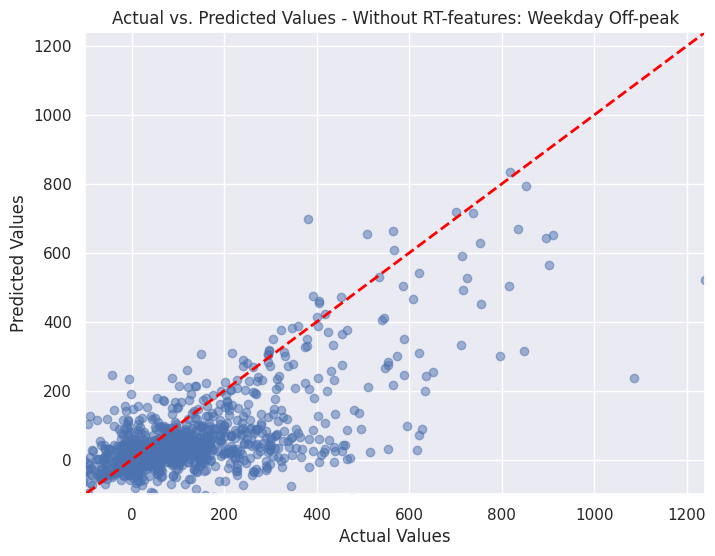

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error: 144.9810028076172
Mean Squared Error: 38573.1328125
Mean Absolute Percentage Error: 1.3177663087844849
Root Mean Square Error: 196.4004364013672
R-squared: 0.07758557796478271
Maximum error: 1332.600118637085


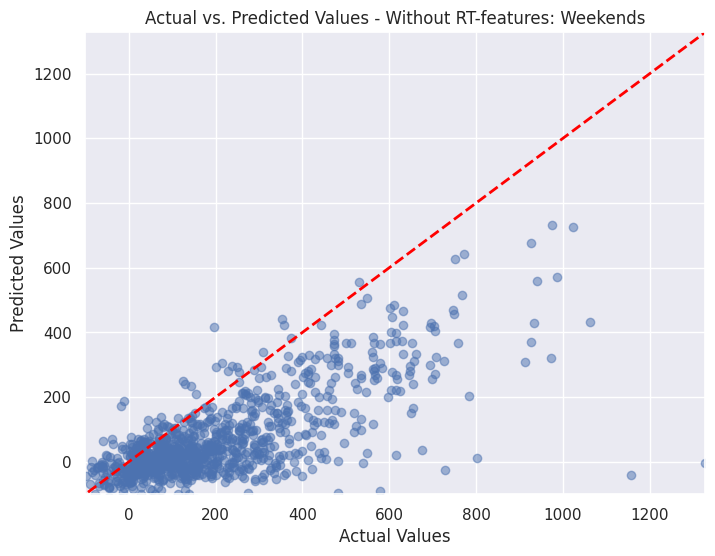

In [49]:

from sklearn.preprocessing import StandardScaler
%matplotlib inline

'''Tests of NN-models on off-peak and weekend data - Random sample of 1000 entries
Non-RT scenario'''

#Scaler for input features
scaler = StandardScaler()

'''Offpeak:'''
df_nrt_offpeak = df_offpeak.drop(['upstream_stop_delay','previous_bus_delay','previous_trip_travel_time','travel_time_for_previous_section','dwell_time'], axis = 1)
df_nrt_offpeak_test = df_nrt_offpeak.sample(n=1000, random_state=21)
y_nrt_offpeak_test = df_nrt_offpeak_test['arrival_delay']
x_nrt_offpeak_test = scaler.fit_transform(df_nrt_offpeak_test.drop(['arrival_delay'], axis=1))


#Test prediction accuracy for off-peaks using trained model
y_nrt_offpeak_pred = best_nrt_model.predict(x_nrt_offpeak_test)

assessModel(y_nrt_offpeak_test, y_nrt_offpeak_pred)
#Plot predictions:
plotPredictions(y_nrt_offpeak_test, y_nrt_offpeak_pred, 'Without RT-features: Weekday Off-peak')

'''Weekend:'''
df_nrt_weekend = df_weekend.drop(['upstream_stop_delay','previous_bus_delay','previous_trip_travel_time','travel_time_for_previous_section','dwell_time'], axis = 1)
df_nrt_weekend_test = df_nrt_weekend.sample(n=1000, random_state=21)
y_nrt_weekend_test = df_nrt_weekend_test['arrival_delay']
x_nrt_weekend_test = scaler.fit_transform(df_nrt_weekend_test.drop(['arrival_delay'], axis=1))

#Test prediction accuracy for weekends using trained model
y_nrt_weekend_pred = best_nrt_model.predict(x_nrt_weekend_test)

assessModel(y_nrt_weekend_test, y_nrt_weekend_pred)

#Plot predictions:
plotPredictions(y_nrt_weekend_test, y_nrt_weekend_pred, 'Without RT-features: Weekends')







32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error: 43.01951599121094
Mean Squared Error: 2213.126953125
Mean Absolute Percentage Error: 379659506155520.0
Root Mean Square Error: 47.04388427734375
R-squared: 0.933552086353302
Maximum error: 246.07119750976562


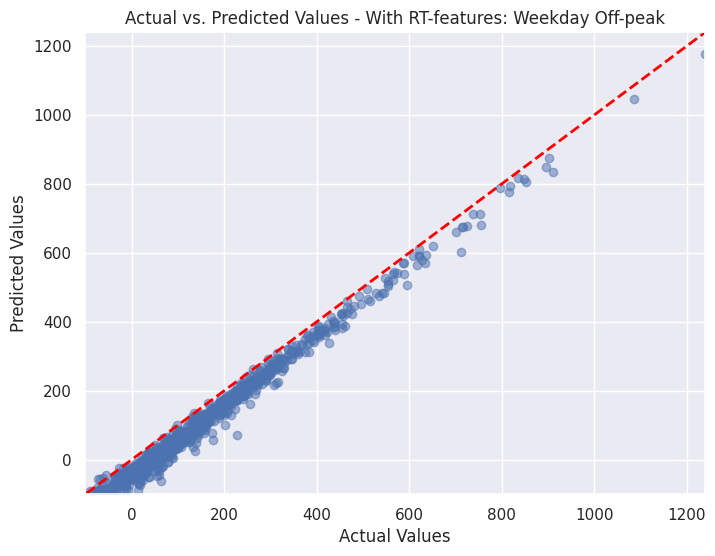

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error: 108.1693115234375
Mean Squared Error: 12670.4248046875
Mean Absolute Percentage Error: 1.8635728359222412
Root Mean Square Error: 112.56298065185547
R-squared: 0.6970071792602539
Maximum error: 246.47097778320312


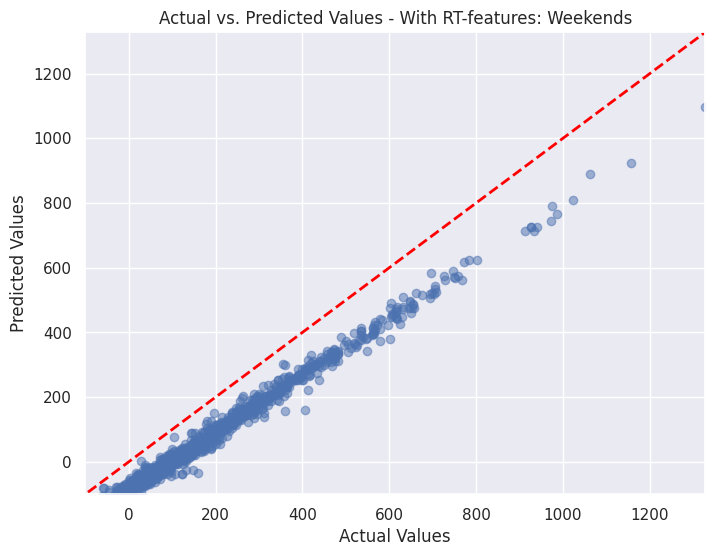

In [50]:

from sklearn.preprocessing import StandardScaler
%matplotlib inline

'''Tests of NN-models on off-peak and weekend data - Random sample of 1000 entries
RT scenario'''

df_offpeak_test = df_offpeak.sample(n=1000, random_state=21)
df_weekend_test = df_weekend.sample(n=1000, random_state=21)
scaler2 = StandardScaler()

'''Offpeak:'''
y_offpeak_test = df_offpeak_test['arrival_delay']
x_offpeak_test = scaler2.fit_transform(df_offpeak_test.drop(['arrival_delay'], axis=1))

#Test prediction accuracy for off-peaks using trained model
y_offpeak_pred = best_model.predict(x_offpeak_test)

assessModel(y_offpeak_test, y_offpeak_pred)

#Plot predictions:
plotPredictions(y_offpeak_test, y_offpeak_pred, 'With RT-features: Weekday Off-peak')

'''Weekend:'''
y_weekend_test = df_weekend_test['arrival_delay']
x_weekend_test = scaler2.fit_transform(df_weekend_test.drop(['arrival_delay'], axis=1))

#Test prediction accuracy for weekends using trained model
y_weekend_pred = best_model.predict(x_weekend_test)

assessModel(y_weekend_test, y_weekend_pred)

#Plot predictions:
plotPredictions(y_weekend_test, y_weekend_pred, 'With RT-features: Weekends')


Mean Absolute Error: 12.491717419709795
Mean Squared Error: 322.7298072669267
Mean Absolute Percentage Error: 84451329671553.84
Root Mean Square Error: 17.964682220037368
R-squared: 0.9903102120595209
Maximum error: 195.5725031028735


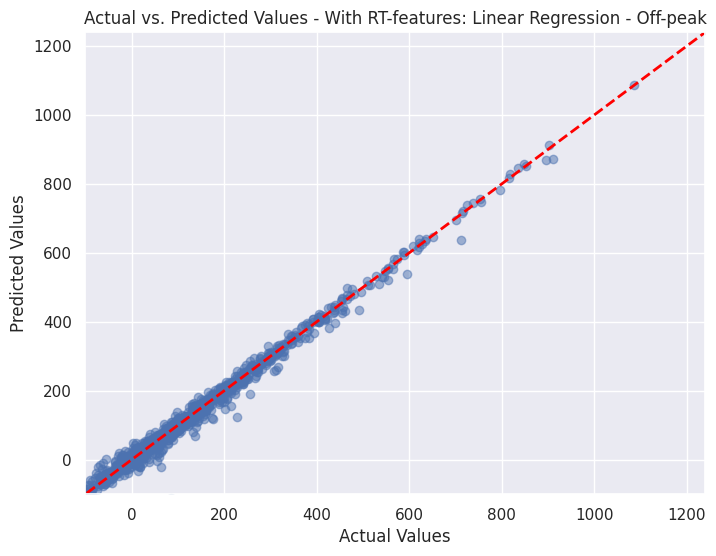

Mean Absolute Error: 10.475283124215334
Mean Squared Error: 234.9650249456744
Mean Absolute Percentage Error: 0.2589497685701467
Root Mean Square Error: 15.328568913818224
R-squared: 0.994381188799365
Maximum error: 120.68903035207165


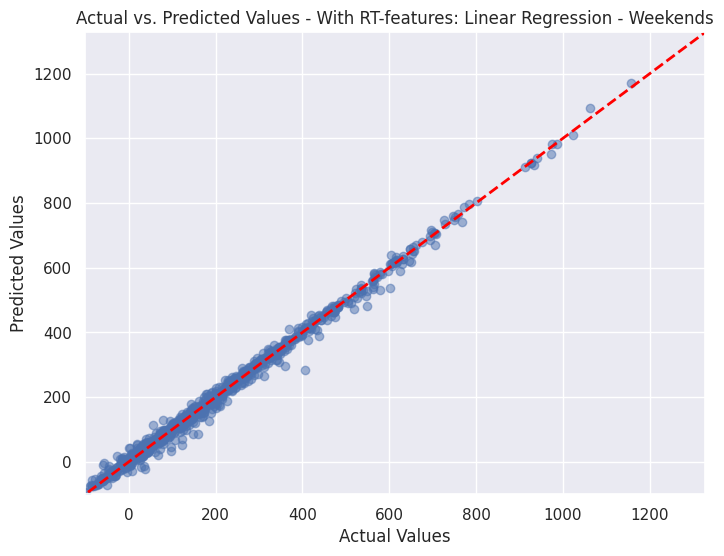

Mean Absolute Error: 97.0273491690408
Mean Squared Error: 18803.33909446967
Mean Absolute Percentage Error: 857073081254040.1
Root Mean Square Error: 137.12526789206163
R-squared: 0.4354399119767792
Maximum error: 858.2513288450335


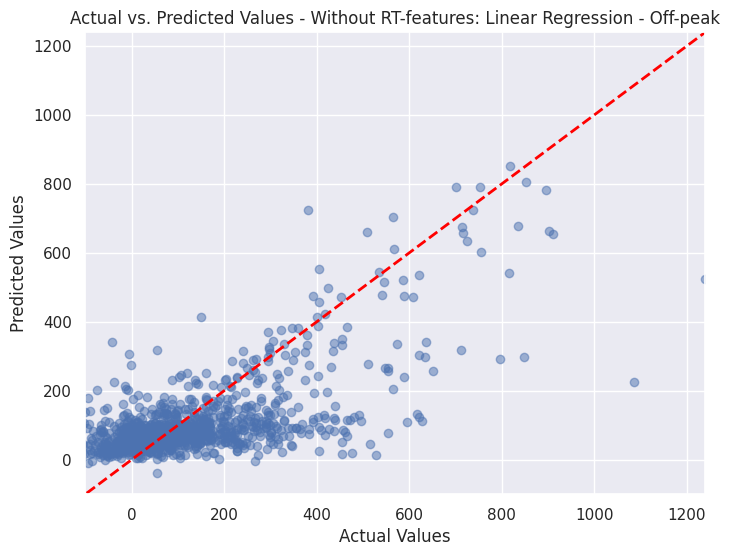

Mean Absolute Error: 100.96996354369556
Mean Squared Error: 20999.84335539281
Mean Absolute Percentage Error: 1.399677541711207
Root Mean Square Error: 144.91322698564412
R-squared: 0.4978224734334731
Maximum error: 1188.4526143357116


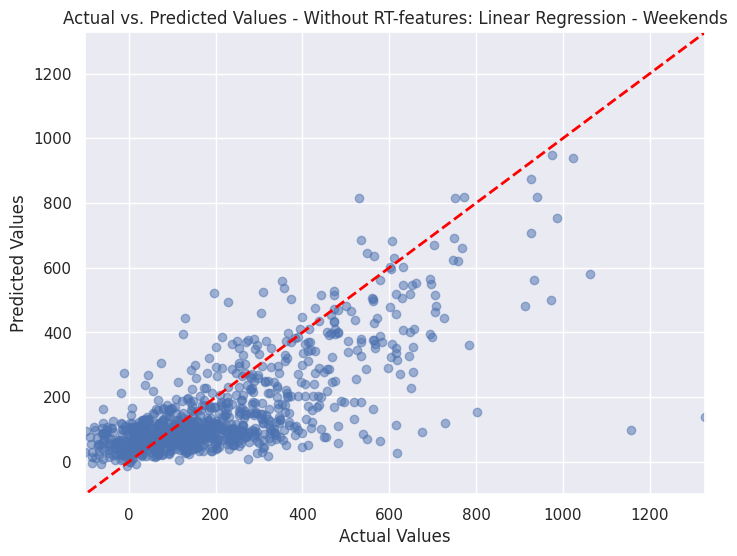

In [51]:
'''Tests ffor weekends and off-peaks -'''
'''Linear Regression - With RT'''

#Unscaled x for use by linear regression
x_offpeak_test_uc = df_offpeak_test.drop(['arrival_delay'], axis=1)
x_weekend_test_uc = df_weekend_test.drop(['arrival_delay'], axis=1)

#offpeak
lin_offpeak_pred = lin_model.predict(x_offpeak_test_uc)
assessModel(y_offpeak_test, lin_offpeak_pred)
plotPredictions(y_offpeak_test, lin_offpeak_pred, 'With RT-features: Linear Regression - Off-peak')

#weekends
lin_weekend_pred = lin_model.predict(x_weekend_test_uc)
assessModel(y_weekend_test, lin_weekend_pred)
plotPredictions(y_weekend_test, lin_weekend_pred, 'With RT-features: Linear Regression - Weekends')


'''without RT'''
x_nrt_offpeak_test = x_offpeak_test_uc.drop(['upstream_stop_delay','previous_bus_delay','previous_trip_travel_time','travel_time_for_previous_section','dwell_time'], axis = 1)
x_nrt_weekend_test = x_weekend_test_uc.drop(['upstream_stop_delay','previous_bus_delay','previous_trip_travel_time','travel_time_for_previous_section','dwell_time'], axis = 1)

#offpeak
lin_offpeak_pred = lin_model_nrt.predict(x_nrt_offpeak_test)
assessModel(y_offpeak_test, lin_offpeak_pred)
plotPredictions(y_offpeak_test, lin_offpeak_pred, 'Without RT-features: Linear Regression - Off-peak')

#weekends
lin_weekend_pred = lin_model_nrt.predict(x_nrt_weekend_test)
assessModel(y_weekend_test, lin_weekend_pred)
plotPredictions(y_weekend_test, lin_weekend_pred, 'Without RT-features: Linear Regression - Weekends')


# XGboost-model

In [52]:

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

def doGridSearch(model, param_grid, cross_v, training_x, training_y):
  #`grid_search` performs a grid search with x-fold cross-validation and evaluates the models based on accuracy. Returns the best scoring model
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cross_v, scoring='r2')
  grid_search.fit(training_x, training_y)
  print(grid_search.best_params_)
  print(grid_search.best_score_)
  return grid_search.best_estimator_

XGBModel = XGBRegressor()
param_grid = {
    'learning_rate': [0.1, 0.15, 0.25],
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 3, 5]
    }

#Peaks - Non-nrt:
bestXGB_nrt = doGridSearch(XGBModel,param_grid, 5, X_nrt_train, y_nrt_train)
XGB_y_nrt_pred = bestXGB_nrt.predict(X_nrt_test)

assessModel(y_nrt_test, XGB_y_nrt_pred)

bestXGB_nrt.save_model('Best_XGB_nrt')

#Peaks - RT:
bestXGB = doGridSearch(XGBModel,param_grid, 5, X_train, y_train)
XGB_y_pred = bestXGB.predict(X_test)

assessModel(y_test, XGB_y_pred)

#Offpeak - Non-nrt:
XGB_y_nrt_pred_offpeak = bestXGB_nrt.predict(x_nrt_offpeak_test)
print('Offpeak - non-RT')
assessModel(y_offpeak_test, XGB_y_nrt_pred_offpeak)

#Offpeak - RT:
XGB_y_pred_offpeak = bestXGB.predict(x_offpeak_test_uc)
print('Offpeak - RT')
assessModel(y_offpeak_test, XGB_y_pred_offpeak)

#Weekend - Non-nrt:
XGB_y_nrt_pred_weekend = bestXGB_nrt.predict(x_nrt_weekend_test)
print('Weekend - non-RT')
assessModel(y_weekend_test, XGB_y_nrt_pred_weekend)

#Weekend - RT:
XGB_y_pred_weekend = bestXGB.predict(x_weekend_test_uc)
print('Weekend - RT')
assessModel(y_weekend_test, XGB_y_pred_weekend)





{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.4454216122627258
Mean Absolute Error: 92.571533203125
Mean Squared Error: 16650.03125
Mean Absolute Percentage Error: 486460679520256.0
Root Mean Square Error: 129.03500366210938
R-squared: 0.4918794631958008
Maximum error: 675.3278942108154


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1028: UserWarning: [15:53:56] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.963735294342041
Mean Absolute Error: 16.30164909362793
Mean Squared Error: 663.6519775390625
Mean Absolute Percentage Error: 164822406660096.0
Root Mean Square Error: 25.761444091796875
R-squared: 0.9797468781471252
Maximum error: 347.5631408691406
Offpeak - non-RT
Mean Absolute Error: 94.64996337890625
Mean Squared Error: 17302.013671875
Mean Absolute Percentage Error: 832866837594112.0
Root Mean Square Error: 131.53712463378906
R-squared: 0.4805164337158203
Maximum error: 809.6824951171875
Offpeak - RT
Mean Absolute Error: 15.55355453491211
Mean Squared Error: 589.1351318359375
Mean Absolute Percentage Error: 134982383173632.0
Root Mean Square Error: 24.272106170654297
R-squared: 0.9823115468025208
Maximum error: 249.80816650390625
Weekend - non-RT
Mean Absolute Error: 96.80683135986328
Mean Squared Error: 19572.412109375
Mean Absolute Percentage Error: 1.4725390672683716
Root Mean Square Error: 139.9014434814453
R-squared

[14.906853675842285,
 566.7481689453125,
 0.9864471554756165,
 np.float64(183.3720703125)]

Feature: 0, Score: 0.07727
Feature: 1, Score: 0.08291
Feature: 2, Score: 0.45777
Feature: 3, Score: 0.04354
Feature: 4, Score: 0.04107
Feature: 5, Score: 0.01562
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.01612
Feature: 8, Score: 0.01178
Feature: 9, Score: 0.02610
Feature: 10, Score: 0.05849
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.05476
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.11457
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000


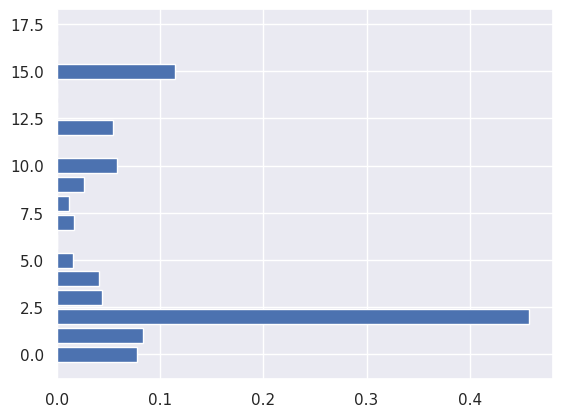

Feature: 0, Score: 0.02280
Feature: 1, Score: 0.04706
Feature: 2, Score: 0.00228
Feature: 3, Score: 0.02659
Feature: 4, Score: 0.84382
Feature: 5, Score: 0.01765
Feature: 6, Score: 0.00440
Feature: 7, Score: 0.00608
Feature: 8, Score: 0.00672
Feature: 9, Score: 0.01694
Feature: 10, Score: 0.00038
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00139
Feature: 13, Score: 0.00076
Feature: 14, Score: 0.00048
Feature: 15, Score: 0.00059
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00063
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00142
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000


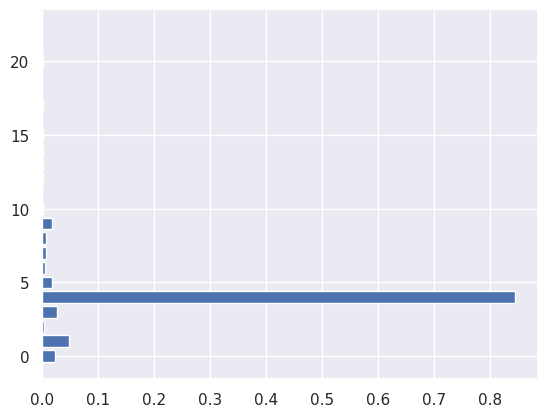

In [58]:
#Investigating feature importance
getFeatureImportance(bestXGB_nrt)
getFeatureImportance(bestXGB)
